In [ ]:
# Install the Google Earth Engine API
!pip install earthengine-api

# Authenticate your GEE account


EEException: ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import ee
import geemap.core as geemap

In [ ]:
import ee

# Trigger the authentication flow
ee.Authenticate()

# Initialize Earth Engine with your project
ee.Initialize(project='ee-hnineiem')

# CSV

In [ ]:
import ee
import geemap
import pandas as pd
from IPython.display import display


small_atlantic_region = ee.Geometry.Rectangle([-80, 30, -75, 45])
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(small_atlantic_region) \
    .filterDate('2020-01-01', '2021-01-01') \
    .limit(1000)


def add_cloud_score(image):
    scored = ee.Algorithms.Landsat.simpleCloudScore(image)
    cloud_score = scored.select('cloud')

    # Calculate mean cloud score for the entire image
    mean_cloud_score = cloud_score.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e9
    ).get('cloud')

    return image.set('meanCloudScore', mean_cloud_score)

scored_collection = landsat.map(add_cloud_score)
def extract_image_data(image):
    cloud_score = image.get('meanCloudScore')
    # Extract RGB bands
    rgb_bands = image.select(['B4', 'B3', 'B2'])
    # Define a small region to sample the image (to reduce pixel count)
    small_region = image.geometry().buffer(-1000).bounds()

    # Sample the image over this smaller region (avoid too many pixels)
    image_sample = rgb_bands.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=small_region,
        scale=30,
        maxPixels=1e9
    )

    # Extract pixel values
    red = image_sample.get('B4')
    green = image_sample.get('B3')
    blue = image_sample.get('B2')

    return {
        "Red": red.getInfo(),
        "Green": green.getInfo(),
        "Blue": blue.getInfo(),
        "Cloud_Score": cloud_score.getInfo()
    }


image_data_list = []
num_images = scored_collection.size().getInfo()

for i in range(min(1000, num_images)):
    #Get the ith image from the scored_collection
    image = ee.Image(scored_collection.toList(num_images).get(i))
    image_data = extract_image_data(image)
    image_data_list.append(image_data)

df = pd.DataFrame(image_data_list)
df.to_csv('/content/drive/MyDrive/landsat_rgb_To_train.csv', index=False)
display(df)

KeyboardInterrupt: 

# SVM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer


In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/landsat_rgb_To_train.csv")

# Select features and target
X = df[['Red', 'Green', 'Blue']]
y = df['Cloud_Score']

# Handle missing values in target (Cloud_Score)
imputer = SimpleImputer(strategy='mean')
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()  # Reshape and flatten

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_imputed, test_size=0.2, random_state=42)

# Standardize features (SVR is sensitive to feature scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# finding the best parameter

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define pipeline for scaling and SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define hyperparameter grid
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_svr = grid_search.best_estimator_

# Predictions
y_pred_svr_train = best_svr.predict(X_train)
y_pred_svr_test = best_svr.predict(X_test)

# Evaluate performance
mae_train = mean_absolute_error(y_train, y_pred_svr_train)
mae_test = mean_absolute_error(y_test, y_pred_svr_test)

print(f"Best SVR Model: {grid_search.best_params_}")
print(f"SVR Training Mean Absolute Error: {mae_train:.4f}")
print(f"SVR Testing Mean Absolute Error: {mae_test:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVR Model: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
SVR Training Mean Absolute Error: 2.8374
SVR Testing Mean Absolute Error: 2.9470


In [ ]:
# Use the best model found by GridSearchCV
best_svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')  # Best parameters from GridSearch
best_svr.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svr = best_svr.predict(X_test_scaled)

# Evaluate performance
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print(f"Optimized SVR Mean Absolute Error: {mae_svr:.4f}")


Optimized SVR Mean Absolute Error: 2.9470


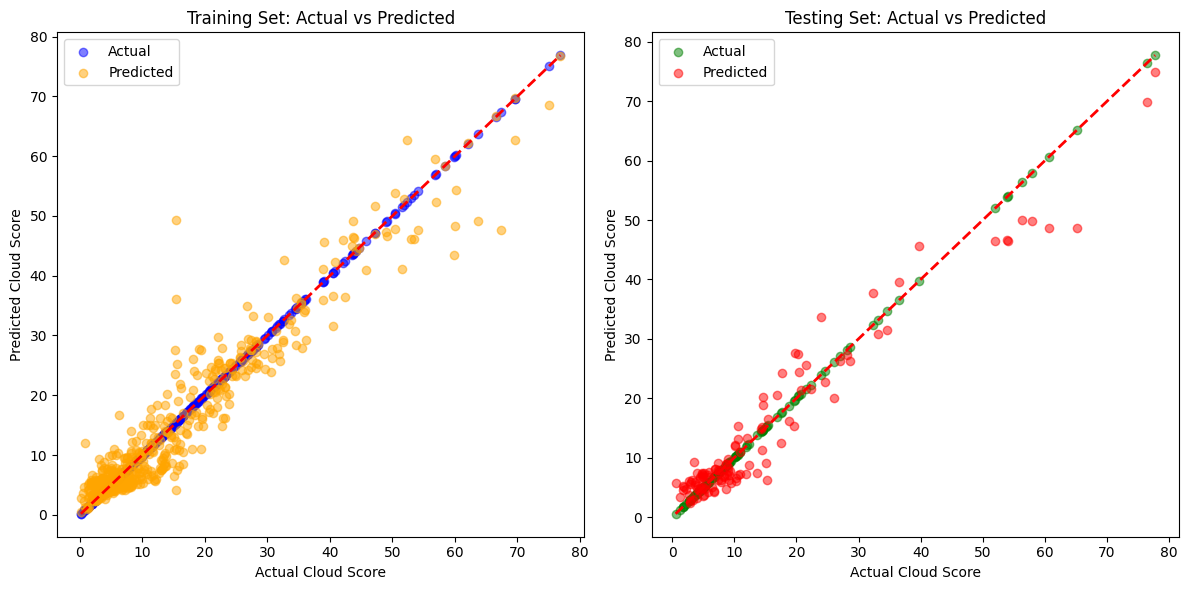

In [ ]:
import matplotlib.pyplot as plt

# Predict on training and testing data
y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# Plot training vs testing predictions
plt.figure(figsize=(12, 6))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train, alpha=0.5, color='blue', label='Actual')
plt.scatter(y_train, y_train_pred, alpha=0.5, color='orange', label='Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Reference line
plt.xlabel("Actual Cloud Score")
plt.ylabel("Predicted Cloud Score")
plt.title("Training Set: Actual vs Predicted")
plt.legend()

# Testing set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test, alpha=0.5, color='green', label='Actual')
plt.scatter(y_test, y_test_pred, alpha=0.5, color='red', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Reference line
plt.xlabel("Actual Cloud Score")
plt.ylabel("Predicted Cloud Score")
plt.title("Testing Set: Actual vs Predicted")
plt.legend()

plt.tight_layout()
plt.show()


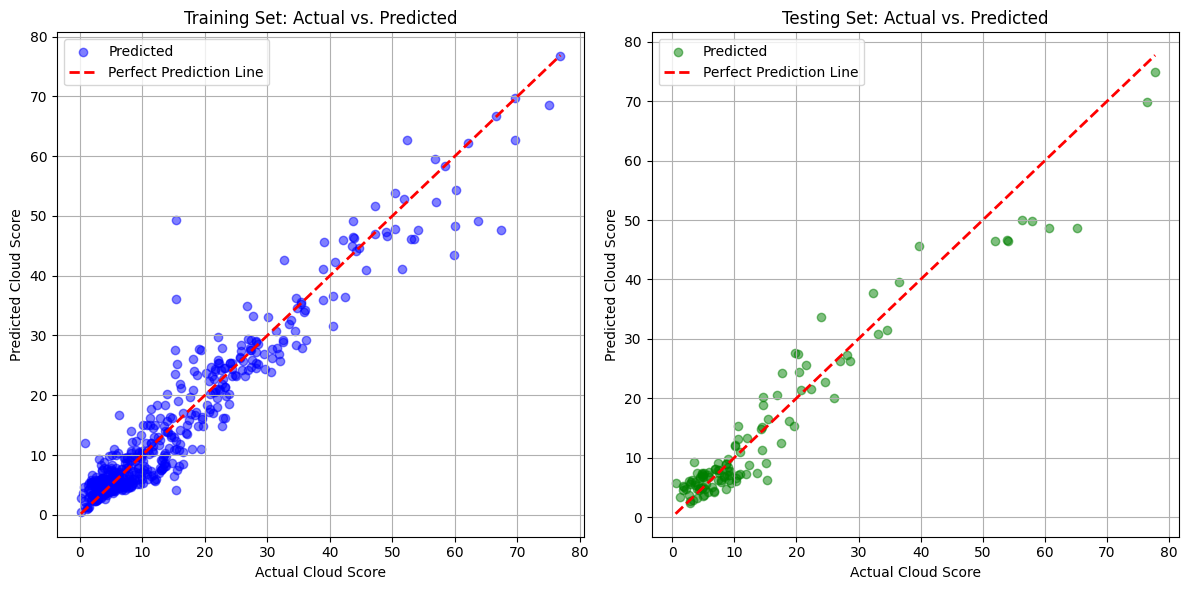

In [ ]:
import matplotlib.pyplot as plt

# Predict on both training and testing data
y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# 🔹 Training Set Plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue', label="Predicted")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', lw=2, label="Perfect Prediction Line")
plt.xlabel("Actual Cloud Score")
plt.ylabel("Predicted Cloud Score")
plt.title("Training Set: Actual vs. Predicted")
plt.legend()
plt.grid(True)

# 🔹 Testing Set Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green', label="Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label="Perfect Prediction Line")
plt.xlabel("Actual Cloud Score")
plt.ylabel("Predicted Cloud Score")
plt.title("Testing Set: Actual vs. Predicted")
plt.legend()
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
